In [ ]:
# import zipfile
# with zipfile.ZipFile("Data.zip","r") as zip_ref:
#     zip_ref.extractall("GTZAN_Dataset")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import os
import sys
import librosa
import pickle
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras as k
import IPython
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.callbacks import Callback

In [ ]:
%cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
# Load the dataset containing features extracted from 3-second audio clips
audio_features_dataframe = pd.read_csv('Data/features_3_sec.csv')
# Display the first five rows to check the correct import of data
audio_features_dataframe.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
audio_features_dataframe.shape

(9990, 60)

In [ ]:
audio_features_dataframe.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [ ]:
# Remove the 'filename' column as it's not required for data processing
audio_features_dataframe = audio_features_dataframe.drop(columns=['filename'])


In [ ]:
# Define the path to the audio file and load it using Librosa
audio_file_path = "Data/genres_original/country/country.00050.wav"
audio_signal, sample_rate = librosa.load(audio_file_path)
# Verify the types of the loaded audio data and sample rate
print(f"Audio signal type: {type(audio_signal)}, Sample rate type: {type(sample_rate)}")

Audio signal type: <class 'numpy.ndarray'>, Sample rate type: <class 'int'>


In [ ]:
# Load the audio file and explicitly set the sample rate to 45.6 kHz
loaded_audio_signal, audio_sample_rate = librosa.load(audio_file_path, sr=45600)
# Confirming the sample rate and data type
print(f"Sample rate: {audio_sample_rate}, Signal Type: {type(loaded_audio_signal)}")

Sample rate: 45600, Signal Type: <class 'numpy.ndarray'>


In [ ]:
librosa.load(audio_file_path, sr=45600)

(array([ 0.04446704,  0.06373047,  0.05768819, ..., -0.13878524,
        -0.11868108, -0.05903753], dtype=float32),
 45600)

In [ ]:
# Use IPython's Audio class to play the loaded audio signal in the notebook
IPython.display.Audio(audio_signal, rate=sample_rate)


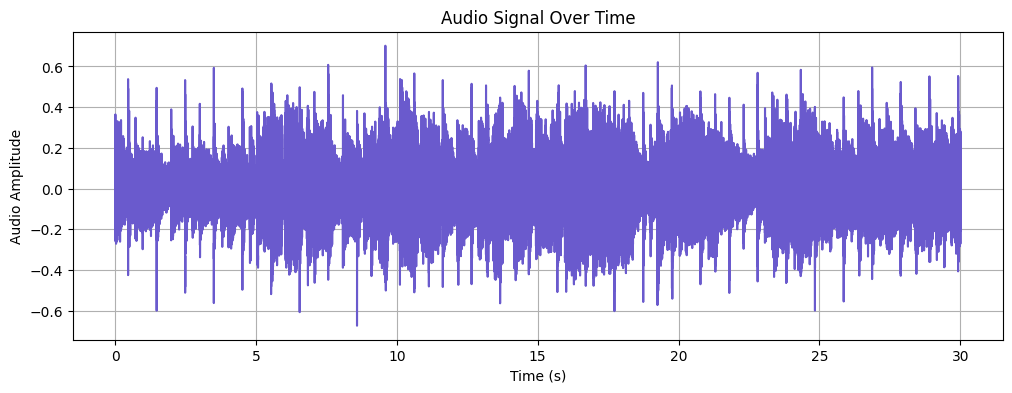

In [ ]:
# Generate a time axis for the audio signal, considering the sample rate for accurate representation
audio_duration = np.arange(0, len(loaded_audio_signal)) / audio_sample_rate

# Set up the figure for plotting the audio signal with time on the x-axis and amplitude on the y-axis
plt.figure(figsize=(12, 4))
signal_color = 'slateblue'
plt.plot(audio_duration, loaded_audio_signal, color=signal_color)
plt.xlabel('Time (s)')
plt.ylabel('Audio Amplitude')
plt.title('Audio Signal Over Time')
plt.grid(True)  # Add a grid to the plot for better readability of the scale
plt.show()

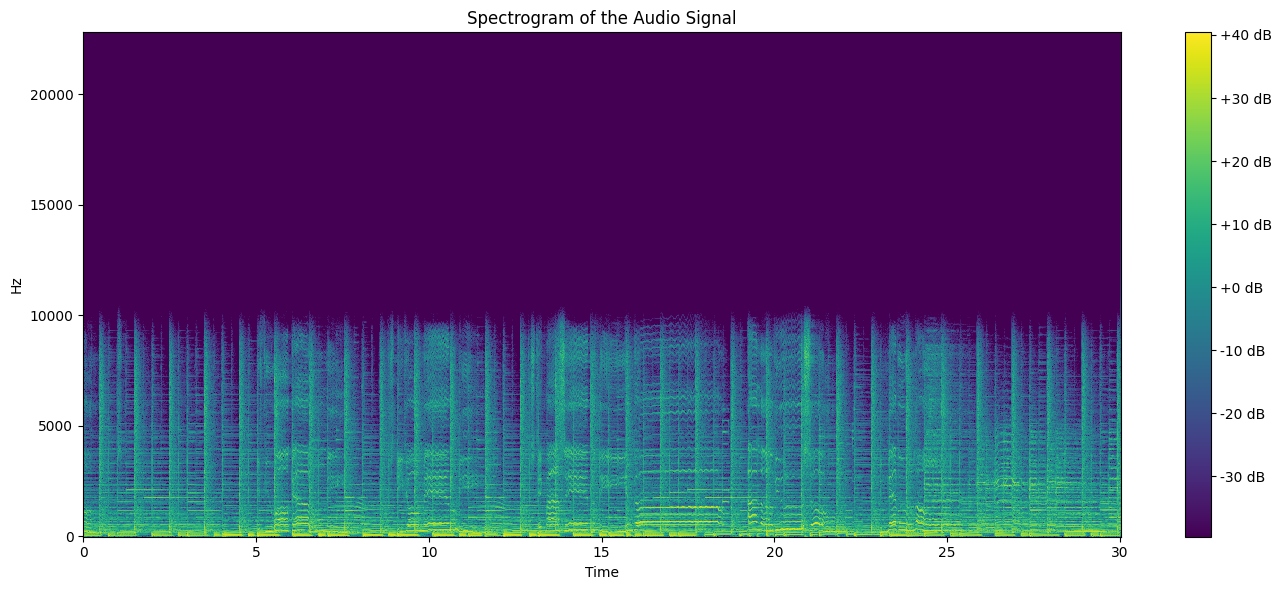

In [ ]:
# Compute the Short-Time Fourier Transform (STFT) of the audio signal
audio_stft = librosa.stft(loaded_audio_signal)

# Convert the STFT output to decibels (dB) to visualize the magnitude
audio_stft_db = librosa.amplitude_to_db(np.abs(audio_stft))

# Set up the figure for plotting the spectrogram
plt.figure(figsize=(14, 6))
spectrogram_color_map = 'viridis'  # A commonly used color map for spectrograms

# Display the spectrogram with appropriate axes labels and color map
librosa.display.specshow(audio_stft_db, sr=audio_sample_rate, x_axis='time', y_axis='hz', cmap=spectrogram_color_map)
plt.colorbar(format='%+2.0f dB')  # Show colorbar with label indicating decibels
plt.title('Spectrogram of the Audio Signal')  # Add a descriptive title
plt.tight_layout()  # Adjust layout to fit all elements neatly
plt.show()

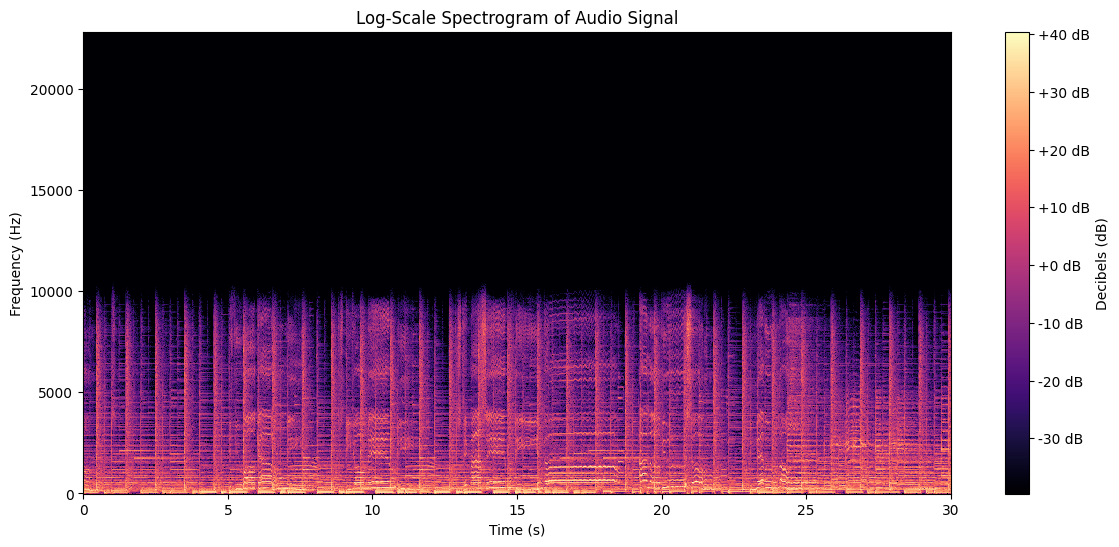

In [ ]:
# Perform the Short-Time Fourier Transform on the audio signal to analyze frequency components
transformed_audio = librosa.stft(loaded_audio_signal)

# Convert the magnitude of the STFT to a logarithmic scale (decibels)
log_scale_stft = librosa.amplitude_to_db(np.abs(transformed_audio))

# Initialize a new figure with customized dimensions for a clear visualization
plt.figure(figsize=(14, 6))

# Plot the spectrogram with the logarithmic scale information
specshow_color_map = 'magma'  # Choosing a different color map for visual distinction
librosa.display.specshow(log_scale_stft, sr=audio_sample_rate, x_axis='time', y_axis='hz', cmap=specshow_color_map)

# Add a colorbar to the plot to interpret the spectrogram correctly, with a label for units
plt.colorbar(format='%+2.0f dB', label='Decibels (dB)')

# Enhancing the plot with titles and labels for a complete understanding
plt.title('Log-Scale Spectrogram of Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

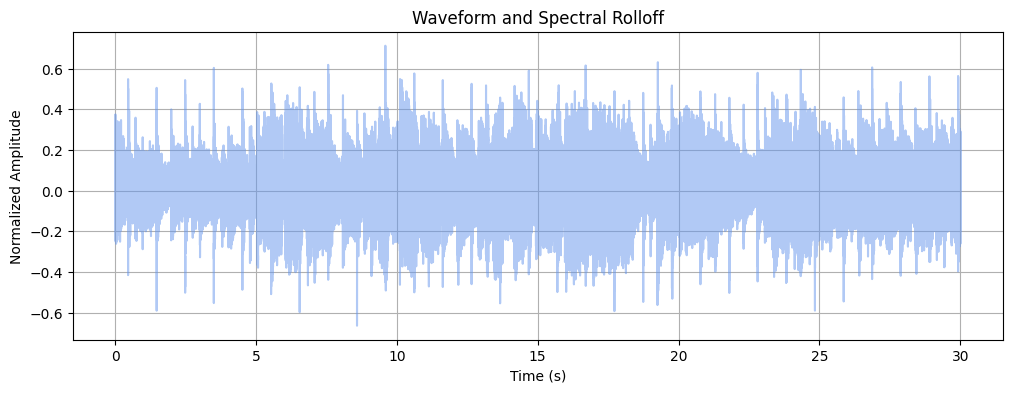

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa.feature import spectral_rolloff

# Load the audio file and adjust the signal
audio_signal_adjusted = loaded_audio_signal + 0.01

# Compute the spectral rolloff point of the adjusted audio signal
rolloff_frequency = spectral_rolloff(y=audio_signal_adjusted, sr=audio_sample_rate)[0]

# Prepare the time axis for the audio data
time_axis = np.linspace(0, len(loaded_audio_signal) / audio_sample_rate, len(loaded_audio_signal))

# Create a plot of the audio waveform with transparency
plt.figure(figsize=(12, 4))
waveform_plot_color = 'cornflowerblue'  # Changed color for a new aesthetic
plt.plot(time_axis, audio_signal_adjusted, alpha=0.5, color=waveform_plot_color)  # Adjusted alpha for better visibility
plt.xlabel('Time (s)')  # Abbreviated 'seconds' to 's' for the x-axis label
plt.ylabel('Normalized Amplitude')  # Added 'Normalized' to the y-axis label to reflect the signal adjustment
plt.title('Waveform and Spectral Rolloff')  # Added a title to the plot
plt.grid(True)  # Enabled grid for better readability of the plot
plt.show()


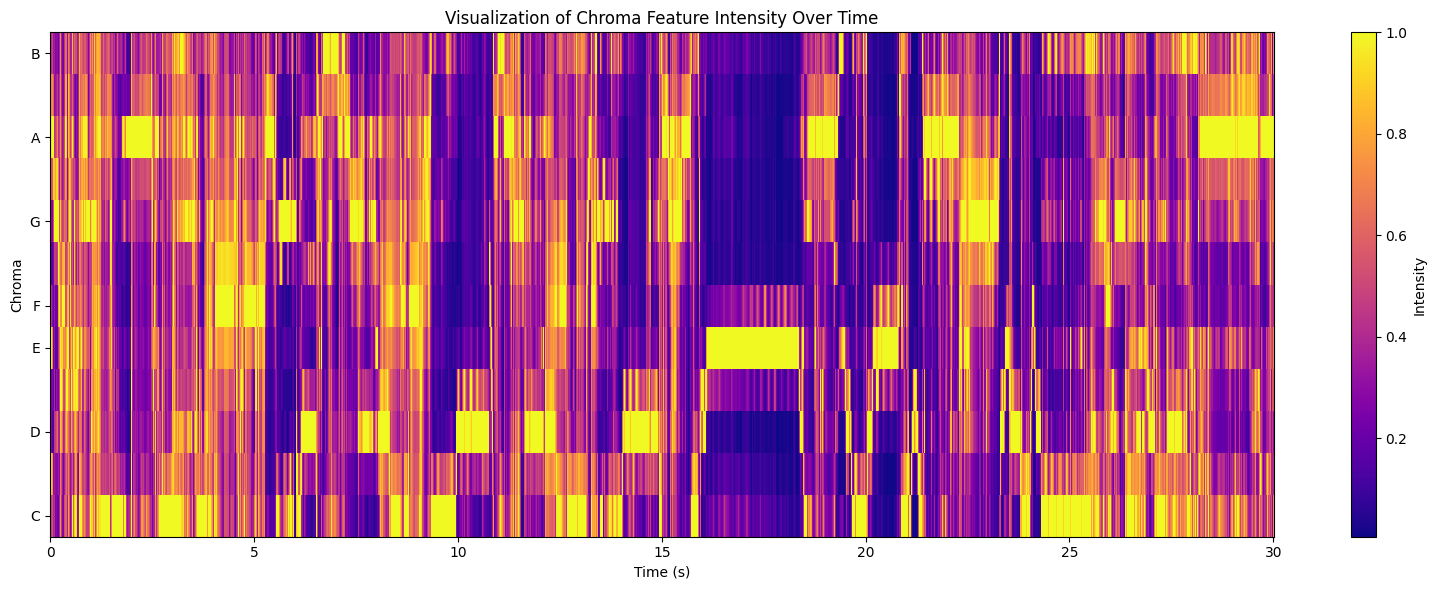

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file to analyze the chroma features
audio_signal_for_chroma = loaded_audio_signal  # Assuming loaded_audio_signal is the audio data array
sample_rate_for_chroma = audio_sample_rate  # Assuming audio_sample_rate is the sample rate

# Compute the chroma feature matrix for the audio signal
chroma_feature_matrix = librosa.feature.chroma_stft(y=audio_signal_for_chroma, sr=sample_rate_for_chroma)

# Set up the figure for displaying the chroma features
plt.figure(figsize=(16, 6))

# Display the chroma feature matrix with an appropriate color map
chroma_color_map = 'plasma'
librosa.display.specshow(chroma_feature_matrix, sr=sample_rate_for_chroma, x_axis='time', y_axis='chroma', cmap=chroma_color_map)

# Add a colorbar with a label to interpret the chroma values
plt.colorbar(label='Intensity')

# Add a title and labels for a complete and informative plot
plt.title('Visualization of Chroma Feature Intensity Over Time')
plt.xlabel('Time (s)')  # Label for the x-axis
plt.ylabel('Chroma')  # Label for the y-axis
plt.tight_layout()  # Adjust layout
plt.show()

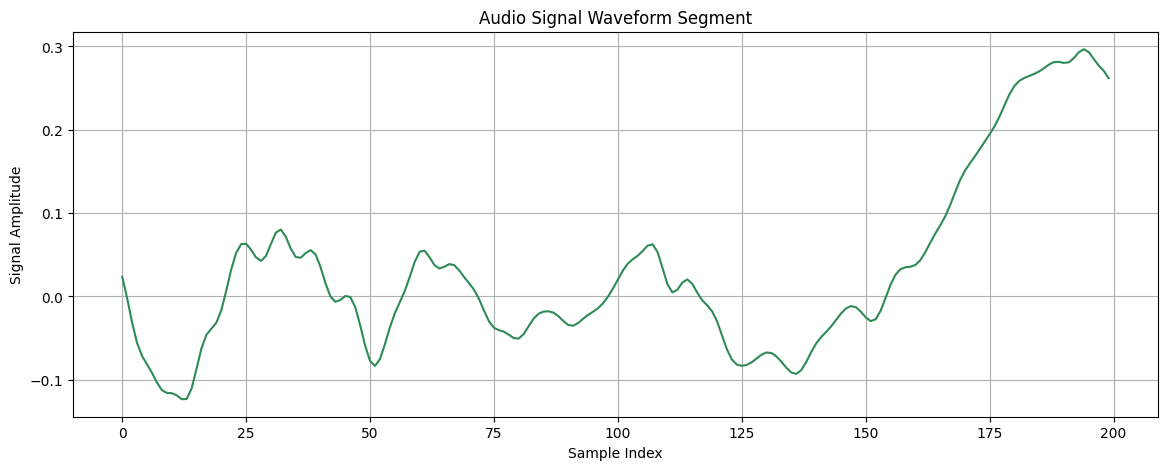

In [ ]:
# Define the start and end sample indices for plotting a segment of the audio signal
segment_start_idx = 1000
segment_end_idx = 1200

# Set up the figure with specified dimensions for a clear view of the waveform segment
plt.figure(figsize=(14, 5))

# Plot the specified segment of the audio signal waveform with a new color
waveform_segment_color = 'seagreen'
plt.plot(loaded_audio_signal[segment_start_idx:segment_end_idx], color=waveform_segment_color)

# Enhance the plot with a grid for better readability of the data points
plt.grid(True)

# Adding descriptive labels and title for the plot
plt.xlabel('Sample Index')  # Label for the x-axis indicating sample indices
plt.ylabel('Signal Amplitude')  # Label for the y-axis indicating amplitude
plt.title('Audio Signal Waveform Segment')  # A title describing the plot

# Display the plot
plt.show()

In [ ]:
# Calculate the number of times the audio signal crosses the zero-amplitude axis
# in the specified segment without padding
audio_segment_start = 1000  # Starting index for the audio segment
audio_segment_end = 1200    # Ending index for the audio segment
zero_crossings_count = librosa.zero_crossings(loaded_audio_signal[audio_segment_start:audio_segment_end], pad=False)

# Output the calculated number of zero-crossings in the segment
print(f"Count of zero amplitude crossings in segment: {sum(zero_crossings_count)}")

Count of zero amplitude crossings in segment: 10


In [ ]:
# Extract genre labels or class identifiers from the last column of the DataFrame
genre_labels = audio_features_dataframe.iloc[:, -1]

# Initialize a label encoder to convert text labels into numerical format
label_encoder = LabelEncoder()

In [ ]:
# Encode the textual genre labels into a numerical format suitable for machine learning models
encoded_genres = label_encoder.fit_transform(genre_labels)

In [ ]:
np.unique(encoded_genres)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
print(audio_features_dataframe.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [ ]:
# Select all features from the DataFrame, excluding the last column which typically contains labels
audio_feature_data = audio_features_dataframe.iloc[:, :-1]

In [ ]:
# Initialize a standard scaler for feature normalization
feature_scaler = StandardScaler()

# Convert the feature data to a numpy array of type float and apply scaling
scaled_features = feature_scaler.fit_transform(np.array(audio_feature_data, dtype=float))

In [ ]:
# Split the scaled feature set and encoded labels into training and testing subsets
# Here, 33% of the data is reserved for testing
training_features, testing_features, training_labels, testing_labels = train_test_split(scaled_features, encoded_genres, test_size=0.33)

In [ ]:
len(training_labels)

6693

In [ ]:
len(testing_labels)

3297

Building the Model

In [ ]:
def train_audio_classifier(neural_network, num_epochs, chosen_optimizer, training_callbacks=None):
    training_batch_size = 128
    neural_network.compile(optimizer=chosen_optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
    return neural_network.fit(training_features, training_labels,
                              validation_data=(testing_features, testing_labels),
                              epochs=num_epochs,
                              batch_size=training_batch_size,
                              callbacks=training_callbacks)

In [ ]:
def plot_training_results(training_history):
    # Displaying the highest validation accuracy achieved during training
    max_val_accuracy = max(training_history.history['val_accuracy'])
    print(f"Maximum Validation Accuracy: {max_val_accuracy:.2f}")

    # Converting the training history into a DataFrame for visualization
    training_metrics_df = pd.DataFrame(training_history.history)

    # Setting up the plot dimensions and plotting the training history
    plt.figure(figsize=(12, 6))
    training_metrics_df.plot()
    plt.title("Model Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

In [ ]:
class EpochStartCallback(Callback):
    # Custom callback to output a message at the beginning of each epoch
    def on_epoch_start(self, epoch, logs=None):
        print(f"Epoch {epoch+1} is commencing.")

# Constructing the neural network architecture
neural_network = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(training_features.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer to reduce overfitting

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Another dropout layer

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Additional dropout layer

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Further dropout layer

    tf.keras.layers.Dense(10, activation='softmax'),  # Final layer with softmax for classification
])

# Displaying the summary of the neural network
print(neural_network.summary())

# Initializing the custom callback
start_epoch_callback = EpochStartCallback()

# Training the model on a GPU, if available
with tf.device('/GPU:0'):
    training_history = train_audio_classifier(neural_network=neural_network,
                                              num_epochs=600,
                                              chosen_optimizer='adam',
                                              training_callbacks=[start_epoch_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
# Evaluating the neural network performance on the test dataset
evaluation_loss, evaluation_accuracy = neural_network.evaluate(testing_features, testing_labels, batch_size=128)

# Printing the evaluated test loss and accuracy
print(f"Test Loss: {evaluation_loss:.4f}")  # Displaying loss to four decimal places
print(f"Test Accuracy: {evaluation_accuracy * 100:.2f}%")  # Displaying accuracy in percentage format

26/26 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.9269
Test Loss: 0.6612
Test Accuracy: 92.69%


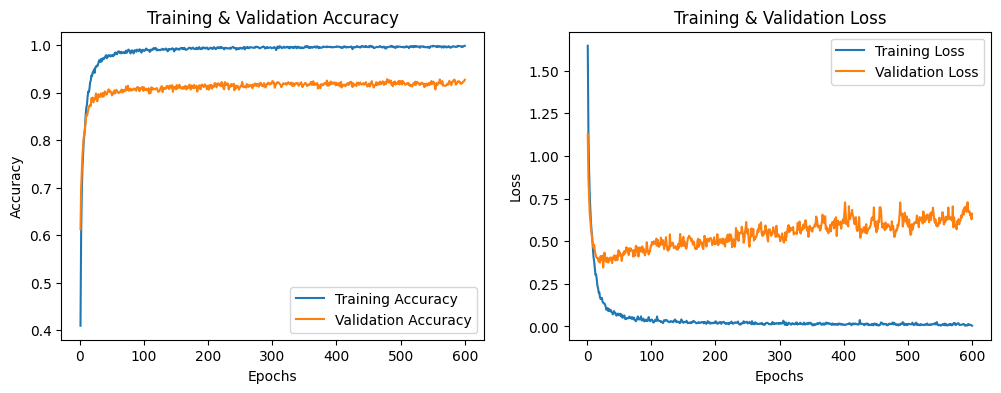

In [ ]:
import matplotlib.pyplot as plt

def learning_curve_plot(history):
    # Extracting training and validation accuracy and loss from the history object
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Counting the number of epochs
    epochs = range(1, len(training_accuracy) + 1)

    # Plotting the training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting the training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

learning_curve_plot(training_history)


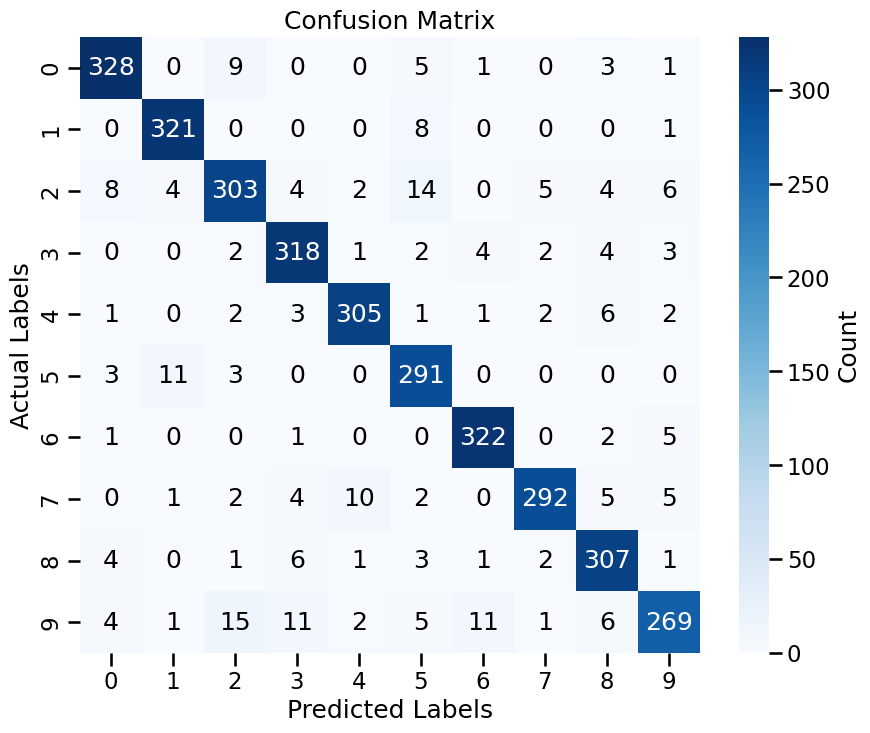

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'cm' is your confusion matrix data
sns.set_context('talk')  # This increases the label font sizes for better readability
plt.figure(figsize=(10, 8))

# Using a different color palette, like 'Blues' or 'Greens' for a different aesthetic
# You can choose from seaborn color palettes like 'rocket', 'mako', 'flare', etc.
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})

# Labels can be improved for clarity as well
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Improve the visibility of the numbers inside the squares based on the color
for text in ax.texts:
    if int(text.get_text()) > 200:  # This threshold can be adjusted as needed
        text.set_color('white')
    else:
        text.set_color('black')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generating a classification report
report = classification_report(testing_labels, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       347
           1       0.95      0.97      0.96       330
           2       0.90      0.87      0.88       350
           3       0.92      0.95      0.93       336
           4       0.95      0.94      0.95       323
           5       0.88      0.94      0.91       308
           6       0.95      0.97      0.96       331
           7       0.96      0.91      0.93       321
           8       0.91      0.94      0.93       326
           9       0.92      0.83      0.87       325

    accuracy                           0.93      3297
   macro avg       0.93      0.93      0.93      3297
weighted avg       0.93      0.93      0.93      3297

